In this demo, I will show you how to use Kubernetes cluster together with Ray, to make a distributed design experiment.

# Kubernetes Cluster Setup


## Cluster Installation

We use the same `docker-desktop` cluster as in the previous demo.

In [1]:
!kubectl config use-context docker-desktop
!kubectl config current-context

Switched to context "docker-desktop".
docker-desktop


<br/>
Check the available nodes.

In [2]:
!kubectl get nodes

NAME             STATUS   ROLES                  AGE   VERSION
docker-desktop   Ready    control-plane,master   34m   v1.21.2


---
## Namespace and Volume

As we did in the previous demo, we create namespace and volume. 
We create the YAML files for each resource and create them using `kubectl apply` command.

In [3]:
!kubectl apply -f rdf-namespace.yaml
!kubectl apply -f pv.yaml
!kubectl apply -f pvc.yaml

namespace/rdf created
persistentvolume/rdf-workspace-pv created
persistentvolumeclaim/rdf-workspace-pv-claim created


---
## Pods

We now create pods. Different from the previous demo, we are going to spawn multiple pods, because we want to create a multi-container cluster.

Specifically, in this demo, we create **2 pods**, each with 2 CPUs available.
For this, we use the following command. 

In [4]:
!helm -n rdf install rdf-ray-cluster ./rdf-ray \
    --set podTypes.rayWorkerType.maxWorkers=1 \
    --set podTypes.rayWorkerType.minWorkers=1 \
    --set podTypes.rayHeadType.CPU=2 \
    --set podTypes.rayWorkerType.CPU=2

NAME: rdf-ray-cluster
LAST DEPLOYED: Thu Jan 13 23:31:21 2022
NAMESPACE: rdf
STATUS: deployed
REVISION: 1
TEST SUITE: None


The above command uses a tool called _Helm Package Manager_, which is used for creating  desired Kubernetes resources efficiently. Although I will skip the details of this command in this demo, you can find more information at our tutorial repository below.

* Link: https://github.com/ieee-ceda-datc/aspdac-2022-tutorial

<br/>
Now, we check the deployed pods. You will see two pods available in the cluster.

In [5]:
!kubectl -n rdf get all

NAME                                        READY   STATUS    RESTARTS   AGE
pod/rdf-ray-cluster-ray-head-type-j6552     1/1     Running   0          21s
pod/rdf-ray-cluster-ray-worker-type-cj9nh   1/1     Running   0          12s

NAME                               TYPE        CLUSTER-IP       EXTERNAL-IP   PORT(S)                       AGE
service/rdf-ray-cluster-ray-head   ClusterIP   10.108.197.205   <none>        10001/TCP,8265/TCP,8000/TCP   21s


---
## Networking


To use the Kubernetes cluster for Ray, we have to expose a network port of the cluster so that Ray can access the Kubernetes pods.
Open a terminal window, and execute the following commands.

```bash
POD=$(kubectl -n rdf get pod -l ray-node-type=head --output=jsonpath={.items..metadata.name})
kubectl -n rdf port-forward $POD 10001
```

---
## Summary

At this point, our Kubernetes cluster has:
    
* **1 node** (local machine).
* **1 storage resource** pointing a local directory having design collateral and PDK/libraries.
* **2 pods**, each running DATC RDF container.
* A network port is expoed so that **Ray** can communicate with the pods and distribute jobs.

<img src="./figs/k8s-single-node-ray.png" alt="k8s-single-node-ray" width="55%"/>

---
# Distributing Tasks with Ray

First, we need to initialize Ray by the following code.

In [6]:
import ray
ray.init("ray://localhost:10001")

ClientContext(dashboard_url=None, python_version='3.9.6', ray_version='1.9.1', ray_commit='2cdbf974ea63caf4323aacbccaef2394a14a8562', protocol_version='2021-09-22', _num_clients=1, _context_to_restore=<ray.util.client._ClientContext object at 0x10b62df10>)

<br/>
And we check the available resources as follows.

In [7]:
ray.available_resources()

{'memory': 6012954214.0,
 'node:10.1.0.24': 1.0,
 'CPU': 4.0,
 'node:10.1.0.25': 1.0,
 'object_store_memory': 19504435113.0}

---

## Testing Ray on Kubernetes Cluster

First, let us test whether Ray distributs tasks in different pods using a simple task.

For this, we define a simple function.

In [8]:
import socket

@ray.remote(num_cpus=2)
def test_ray(x):
    # Wait 1 second.
    import time
    time.sleep(1)
    print("Job {} -- Done (host: {})".format(x+1, socket.gethostname()))

<br/>
We invoke the function 10 times, and see whether Ray distributes it.

In [9]:
obj_refs = [test_ray.remote(i) for i in range(10)]

# Wait until finished
while True:
    _, remaining = ray.wait(obj_refs)
    if len(remaining) == 0:
        break
    obj_refs = remaining

print("Done.")

(test_ray pid=239) Job 1 -- Done (host: rdf-ray-cluster-ray-head-type-j6552)
(test_ray pid=127, ip=10.1.0.25) Job 2 -- Done (host: rdf-ray-cluster-ray-worker-type-cj9nh)
(test_ray pid=239) Job 3 -- Done (host: rdf-ray-cluster-ray-head-type-j6552)
(test_ray pid=127, ip=10.1.0.25) Job 4 -- Done (host: rdf-ray-cluster-ray-worker-type-cj9nh)
(test_ray pid=239) Job 5 -- Done (host: rdf-ray-cluster-ray-head-type-j6552)
(test_ray pid=127, ip=10.1.0.25) Job 6 -- Done (host: rdf-ray-cluster-ray-worker-type-cj9nh)
(test_ray pid=239) Job 7 -- Done (host: rdf-ray-cluster-ray-head-type-j6552)
(test_ray pid=127, ip=10.1.0.25) Job 8 -- Done (host: rdf-ray-cluster-ray-worker-type-cj9nh)
(test_ray pid=239) Job 9 -- Done (host: rdf-ray-cluster-ray-head-type-j6552)
Done.
(test_ray pid=127, ip=10.1.0.25) Job 10 -- Done (host: rdf-ray-cluster-ray-worker-type-cj9nh)


---

## Running Distributed Design Flow Experiment 

We now define a function for distributed experiments.

In this demo, our goal is to **find a maximum achivable utilization for a given design.**

So what we do is:

* Write a function that describes design flow modification and execution.
    1. Copy experiment template (design file, scripts, etc.)
    2. Modify the flow, i.e., change utilization
    3. Execute the flow.
* Put Ray decorator `@ray.remote(...)` at the function definition.

In [10]:
import socket
import subprocess

@ray.remote(num_cpus=2)
def sweep_utilization(util):
    print("FP util {} -- Running at {}".format(util, socket.gethostname()))

    # 1. Copy experiment template
    template = "/workspace/experiment-template"
    workspace = "/workspace/experiment-{}".format(util)
    subprocess.call("cp -r {} {}".format(template, workspace), shell=True)
    
    # 2. Change the utilization.
    with open("{}/config.mk".format(workspace), 'a') as f:
        f.write("\n# Experiment setup:\n")
        f.write("export CORE_UTILIZATION = {}\n".format(util))
    
    # 3. Execute the flow
    subprocess.call("cd {} && make DESIGN_CONFIG=./config.mk".format(workspace), 
                    stdout=subprocess.DEVNULL,
                    shell=True)
    
    print("FP util {} -- Done.".format(util))

<br/>

Now, we run the experiments.

* In this demo, I set the min/max utilization as 40%/60% with 2% step.
* So, the experiments will run 11 times, each with different utilization.

In [11]:
# Min/Max utilization: 40%/60% (step: 2%)
obj_refs = [sweep_utilization.remote(util) for util in range(40, 61, 2)]

while True:
    _, remaining = ray.wait(obj_refs)
    if len(remaining) == 0:
        break
    obj_refs = remaining

print("Experiment done.")

(sweep_utilization pid=127, ip=10.1.0.25) FP util 42 -- Running at rdf-ray-cluster-ray-worker-type-cj9nh
(sweep_utilization pid=239) FP util 40 -- Running at rdf-ray-cluster-ray-head-type-j6552
(sweep_utilization pid=127, ip=10.1.0.25) FP util 42 -- Done.
(sweep_utilization pid=127, ip=10.1.0.25) FP util 44 -- Running at rdf-ray-cluster-ray-worker-type-cj9nh
(sweep_utilization pid=239) FP util 40 -- Done.
(sweep_utilization pid=239) FP util 46 -- Running at rdf-ray-cluster-ray-head-type-j6552
(sweep_utilization pid=239) FP util 46 -- Done.
(sweep_utilization pid=239) FP util 48 -- Running at rdf-ray-cluster-ray-head-type-j6552
(sweep_utilization pid=127, ip=10.1.0.25) FP util 44 -- Done.
(sweep_utilization pid=127, ip=10.1.0.25) FP util 50 -- Running at rdf-ray-cluster-ray-worker-type-cj9nh
(sweep_utilization pid=127, ip=10.1.0.25) FP util 50 -- Done.
(sweep_utilization pid=127, ip=10.1.0.25) FP util 52 -- Running at rdf-ray-cluster-ray-worker-type-cj9nh
(sweep_utilization pid=239) FP 

(sweep_utilization pid=239) make: *** [Makefile:465: results/sky130hd/gcd/base/3_1_place_gp.def] Error 1


(sweep_utilization pid=239) FP util 60 -- Done.


(sweep_utilization pid=239) make: *** [Makefile:465: results/sky130hd/gcd/base/3_1_place_gp.def] Error 1


Experiment done.
(sweep_utilization pid=127, ip=10.1.0.25) FP util 56 -- Done.


---
# Clean-Up Resources

We clean-up the Kubernetes cluster resources.

We first shutdown Ray.

In [12]:
ray.shutdown()

<br />

And delete all the resources by the following commands.

In [13]:
!kubectl -n rdf delete raycluster rdf-ray-cluster
!helm -n rdf uninstall rdf-ray-cluster
!kubectl delete -f pvc.yaml
!kubectl delete -f pv.yaml
!kubectl delete -f rdf-namespace.yaml

raycluster.cluster.ray.io "rdf-ray-cluster" deleted
release "rdf-ray-cluster" uninstalled
persistentvolumeclaim "rdf-workspace-pv-claim" deleted
persistentvolume "rdf-workspace-pv" deleted
namespace "rdf" deleted


---
# Analyze Results

We now check results and find the maximum achivable utilization for the design.

The script below checks the log files and see whether placement succeeded or not.

In [16]:
for util in range(40, 61, 2):
    workspace = "workspace/experiment-{}/logs/sky130hd/gcd/base".format(util)
    with open('{}/3_1_place_gp.log'.format(workspace)) as f:
        lines = [l for l in [_.strip() for _ in f] if l]

    for l in lines:
        if l.startswith("[ERROR GPL-0302]"):    
            print("Floorplan utilization {}%: Unachievable".format(util))
            continue
    try:
        with open('{}/6_report.log'.format(workspace)) as f:
            lines = [l for l in [_.strip() for _ in f] if l]
    except FileNotFoundError:
        continue
    
    for l in lines:
        if l.startswith("Design area"):    
            print("Floorplan utilization {}%: {}".format(util,l))

Floorplan utilization 40%: Design area 2719 u^2 53% utilization.
Floorplan utilization 42%: Design area 2750 u^2 57% utilization.
Floorplan utilization 44%: Design area 2693 u^2 60% utilization.
Floorplan utilization 46%: Design area 2805 u^2 64% utilization.
Floorplan utilization 48%: Design area 2600 u^2 63% utilization.
Floorplan utilization 50%: Design area 2634 u^2 65% utilization.
Floorplan utilization 52%: Design area 2659 u^2 70% utilization.
Floorplan utilization 54%: Design area 2724 u^2 73% utilization.
Floorplan utilization 56%: Design area 2741 u^2 75% utilization.
Floorplan utilization 58%: Unachievable
Floorplan utilization 60%: Unachievable


<br/>

We can also check the layout images to see whether the experiments ran properly or not.

The script below plots all the layout images generated.

<Figure size 432x288 with 0 Axes>

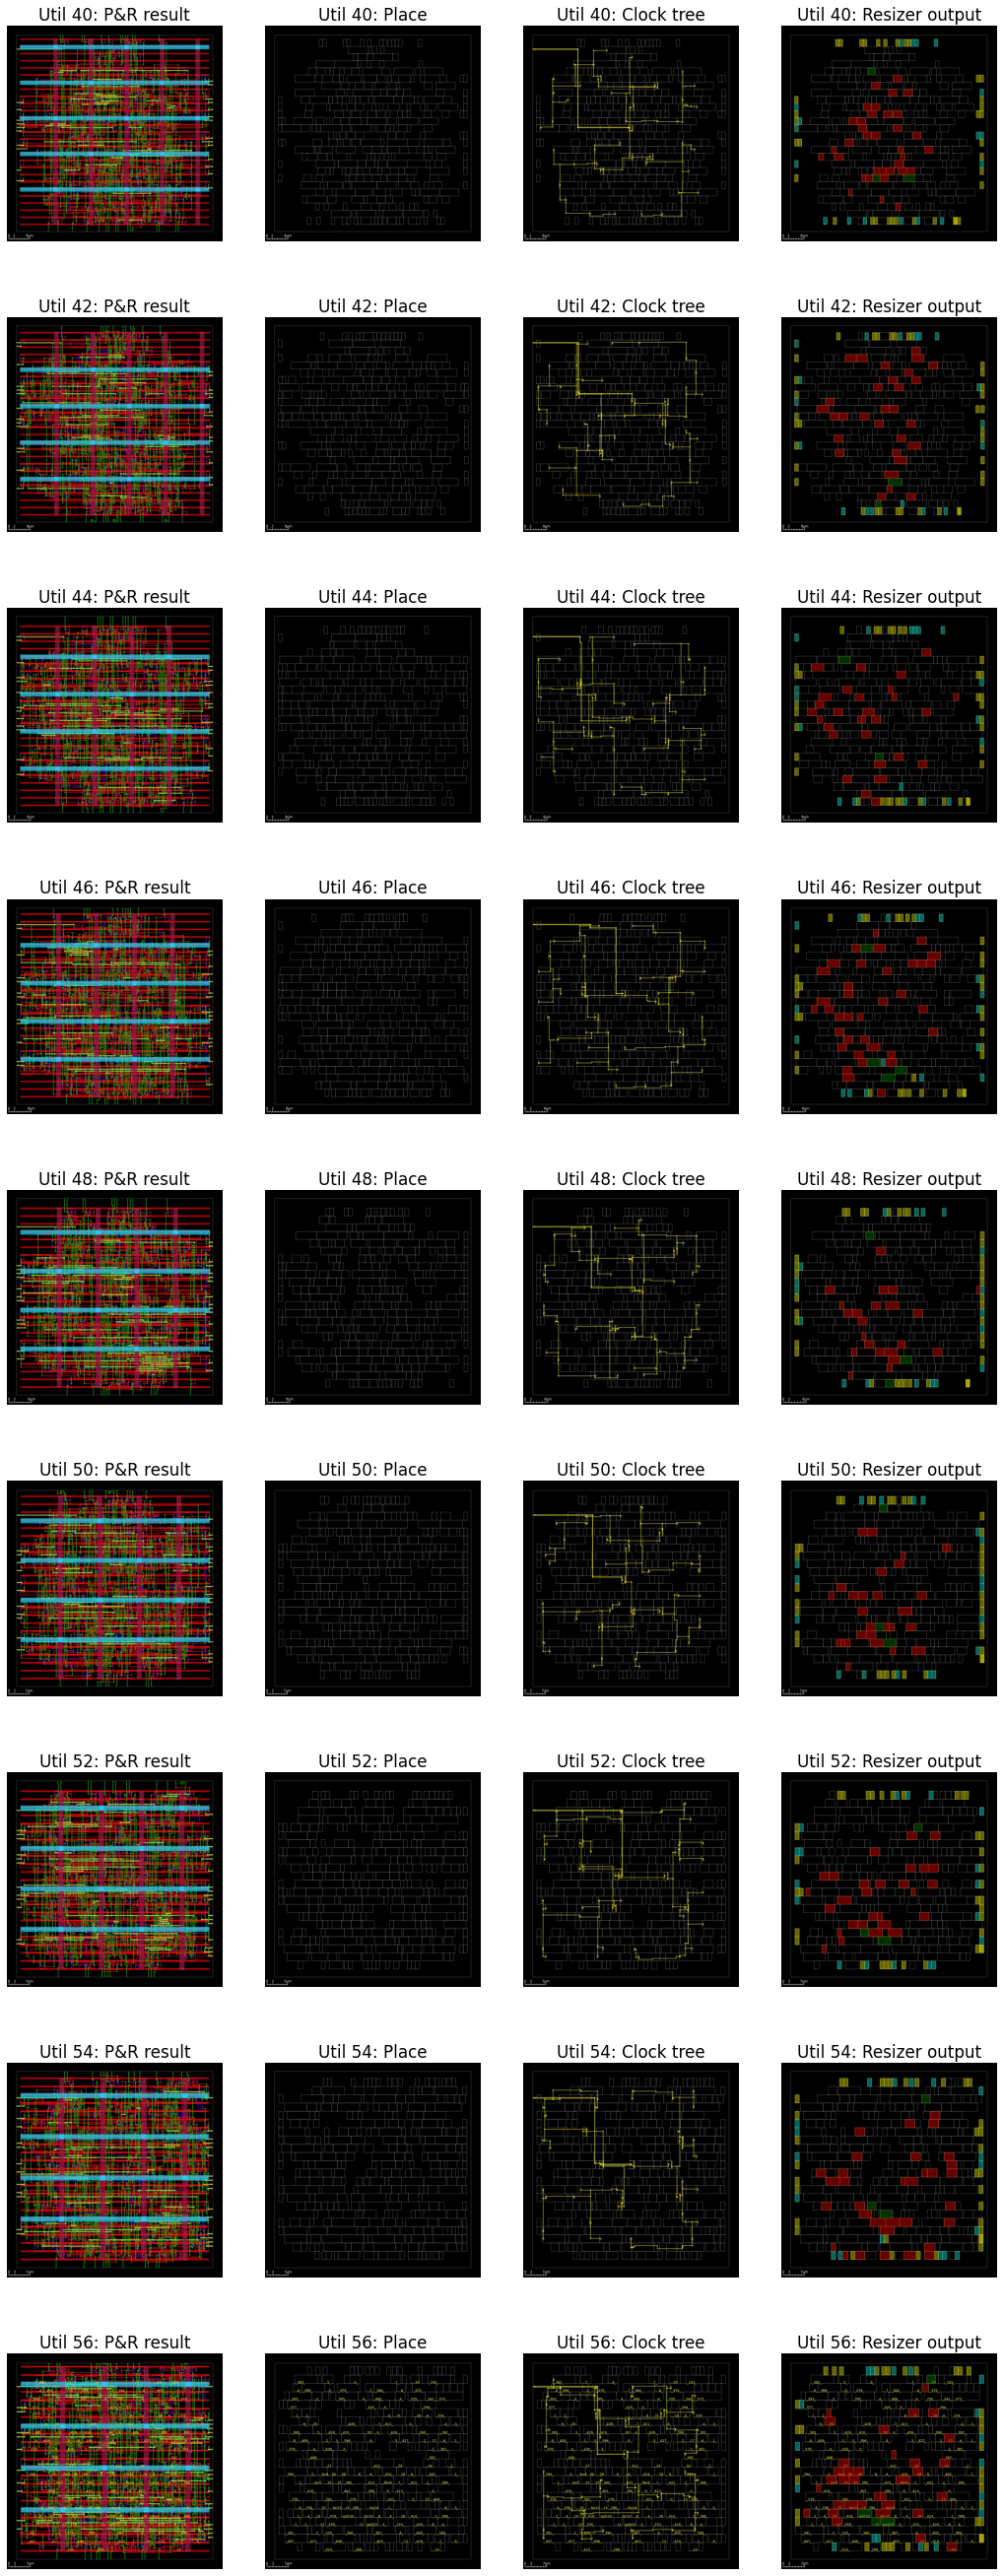

In [17]:
import webp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

fig, axs = plt.subplots(9,4)
fig.set_size_inches(18,48)
[axi.set_axis_off() for axi in axs.ravel()]

for i in range(9):
    util = i*2 + 40
    workspace = "workspace"
    report_dir = "{}/experiment-{}/reports/sky130hd/gcd/base".format(workspace, util)
    pnr = webp.load_image("{}/final.webp".format(report_dir))
    place = webp.load_image("{}/final_placement.webp".format(report_dir))
    clock = webp.load_image("{}/final_clocks.webp".format(report_dir))
    resize = webp.load_image("{}/final_resizer.webp".format(report_dir))

    axs[i][0].imshow(pnr)
    axs[i][1].imshow(place)
    axs[i][2].imshow(clock)
    axs[i][3].imshow(resize)

    axs[i][0].set_title("Util {}: P&R result".format(util))
    axs[i][1].set_title("Util {}: Place".format(util))
    axs[i][2].set_title("Util {}: Clock tree".format(util))
    axs[i][3].set_title("Util {}: Resizer output".format(util))